Import dataset

In [6]:
import numpy as np
import torch
from data.dataset import DatasetLoader
from data.data import TorchGraphData
from preprocessing.normalize import *
from preprocessing.batching_v2 import get_batch_graphs
import math
from typing import List

def flowrate_bc_sin(flowrate, n_edge : int, 
                    n_time : int)->torch.Tensor:
    _flowrate = []
    T = 4.8 # seconds
    for i in range(n_time):
        t = i * T / (n_time - 1)
        value = flowrate(t)
        _flowrate.append(torch.full(size=(n_edge, 1), fill_value=value))
    return torch.cat(_flowrate, dim=1)
        

def normalize(data):
    x = min_max_scaler(data.x, min=0, max=500)
    edge_index = data.edge_index
    edge_attr = min_max_scaler(data.edge_attr,
                min=data.edge_attr.min(axis=0).values,
                max=data.edge_attr.max(axis=0).values)
    pressure = data.pressure * 1e-3
    velocity = data.velocity * 1e-3
    f = lambda t : (np.pi * 1e0 / 4.8) * math.sin(2 * np.pi * t / 4.8)
    flowrate_bc = flowrate_bc_sin(flowrate=f, n_edge=data.edge_attr.size(0),\
                                n_time=data.flowrate.size(1))
    return TorchGraphData(x=x,edge_index=edge_index,edge_attr=edge_attr,
                        pressure=pressure, velocity=velocity, 
                        flowrate_bc=flowrate_bc)

def train_eval_split(dataset : DatasetLoader, train_id : List, eval_id : List,
                    batch_size : int, batch_n_times : int, recursive : bool):
    # Train dataset
    train_dataset = []
    for i in train_id:
        data = normalize(dataset[i])
        train_dataset += get_batch_graphs(data=data, batch_size=batch_size,
                        batch_n_times=batch_n_times, recursive=recursive)
    # Test dataset
    eval_dataset = []
    for i in eval_id:
        data = normalize(dataset[i])
        # eval_dataset += get_batch_graphs(data=data, batch_size=batch_size,
        #                 batch_n_times=batch_n_times, recursive=recursive)
        eval_dataset += [data]

    return train_dataset, eval_dataset

In [8]:
_dataset = DatasetLoader(
    root_dir='/data1/tam/downloaded_datasets_transformed'
)

train_dataset, eval_dataset = train_eval_split(
    dataset=_dataset,
    train_id=list(range(0, 20)),
    eval_id=list(range(20, 40)),
    batch_size=500,
    batch_n_times=50,
    recursive=True
)

Train

In [4]:
import os
import torch
from networks.network_recurrent import RecurrentMeshGraphNet
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from networks.network_recurrent import objectview
CUDA_LAUNCH_BLOCKING=1
torch.cuda.empty_cache()

# Model params
args = objectview({
    'input_dim_node' : dataset[0].x.size(1)+1,
    'input_dim_edge' : dataset[0].edge_attr.size(1)+2,
    'output_dim_node' : 1,
    'output_dim_edge' : 1,
    'hidden_dim' : 64,
    'n_processors' : 10,
    'n_time' : dataset[0].pressure.size(1),
    'device' : torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'lr' : 1e-7,
    'weight_decay' : 5e-4,
    'epoch' : 100,
    'train_id' : list(range(0, 30)),
    'eval_id' : list(range(30, 38))
})

# Model initializing
model = RecurrentMeshGraphNet(
    input_dim_node = args.input_dim_node,
    input_dim_edge = args.input_dim_edge,
    output_dim_node = args.output_dim_node,
    output_dim_edge = args.output_dim_edge,
    hidden_dim = args.hidden_dim,
    n_processors = args.n_processors
)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
criterion = torch.nn.MSELoss()


In [ ]:
# Train function v1
def train(model, data, args):
    n_edge = data.edge_attr.size(0)
    hidden = torch.zeros(n_edge, args.hidden_dim).to(args.device)
    _x = data.x
    edge_index = data.edge_index.to(args.device)
    _edge_attr = data.edge_attr

    total_loss = 0
    for i in range(1, args.n_time):
        model.train()
        optimizer.zero_grad()

        _pressure = data.pressure[:,i-1].unsqueeze(1)
        _velocity = data.velocity[:,i-1].unsqueeze(1)
        x = torch.cat([_x, _pressure], dim=1).to(args.device)
        edge_attr = torch.cat([_edge_attr, _velocity], dim=1).to(args.device)
        node_out, edge_out, hidden = model(x, edge_index, edge_attr, hidden)
        hidden = hidden.detach()

        loss = criterion(node_out, data.pressure[:,i].unsqueeze(1).float().to(args.device))
        loss += criterion(edge_out, data.velocity[:,i].unsqueeze(1).float().to(args.device))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss

# Eval function
def eval(model, data, args):
    n_edge = data.edge_attr.size(0)
    hidden = torch.zeros(n_edge, args.hidden_dim).to(args.device)
    _x = data.x
    edge_index = data.edge_index.to(args.device)
    _edge_attr = data.edge_attr

    total_loss = 0
    for i in range(1, args.n_time):
        model.eval()
        with torch.no_grad():
            _pressure = data.pressure[:,i-1].unsqueeze(1)
            _velocity = data.velocity[:,i-1].unsqueeze(1)
            x = torch.cat([_x, _pressure], dim=1).to(args.device)
            edge_attr = torch.cat([_edge_attr, _velocity], dim=1).to(args.device)
            node_out, edge_out, hidden = model(x, edge_index, edge_attr, hidden)
            hidden = hidden.detach()

            loss = criterion(node_out, data.pressure[:,i].unsqueeze(1).float().to(args.device))
            loss += criterion(edge_out, data.velocity[:,i].unsqueeze(1).float().to(args.device))

            total_loss += loss.item()
    return total_loss
# Training
for epoch in range(args.epoch):
    train_loss = 0
    for i in args.train_id:
        train_loss += train(model=model, data=dataset[i], args=args)
    train_loss /= len(args.train_id)

    eval_loss = 0
    for i in args.eval_id:
        eval_loss += eval(model=model, data=dataset[i], args=args)
    eval_loss /= len(args.eval_id)

    print(f'Epoch {epoch}: train loss = {train_loss}; eval loss = {eval_loss}')

In [ ]:
train_dataset

In [3]:
# Train function v2
def train(model, data, args):
    n_edge = data.edge_attr.size(0)
    hidden = torch.zeros(n_edge, args.hidden_dim).to(args.device)
    _x = data.x #.to(args.device)
    edge_index = data.edge_index.to(args.device)
    _edge_attr = data.edge_attr #.to(args.device)

    _pressure = data.pressure[:,0].unsqueeze(1)
    _velocity = data.velocity[:,0].unsqueeze(1)

    total_loss = 0
    loss = 0
    for i in range(1, args.n_time):
        model.train()
        optimizer.zero_grad()

        _pressure = data.pressure[:,i-1].unsqueeze(1)
        _velocity = data.velocity[:,i-1].unsqueeze(1)
        _flowrate_bc = data.flowrate_bc[:,i].unsqueeze(1)
        x = torch.cat([_x, _pressure], dim=1).to(args.device)
        edge_attr = torch.cat([_edge_attr, _velocity, _flowrate_bc], dim=1).to(args.device)
        node_out, edge_out, hidden = model(x, edge_index, edge_attr, hidden)
        hidden = hidden.detach()
        # _pressure += node_out.detach().cpu()
        # _velocity += edge_out.detach().cpu()

        loss += criterion(node_out, data.pressure[:,i].unsqueeze(1).float().to(args.device))
        loss += criterion(edge_out, data.velocity[:,i].unsqueeze(1).float().to(args.device))

        if i%1==0:
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loss = 0
    return total_loss

# Eval function
def eval(model, data, args):
    n_edge = data.edge_attr.size(0)
    hidden = torch.zeros(n_edge, args.hidden_dim).to(args.device)
    _x = data.x #.to(args.device)
    edge_index = data.edge_index.to(args.device)
    _edge_attr = data.edge_attr #.to(args.device)

    _pressure = data.pressure[:,0].unsqueeze(1)
    _velocity = data.velocity[:,0].unsqueeze(1)

    total_loss = 0
    loss = 0
    for i in range(1, args.n_time):
        model.eval()
        with torch.no_grad():
            # _pressure = data.pressure[:,i-1].unsqueeze(1)
            # _velocity = data.velocity[:,i-1].unsqueeze(1)
            _flowrate_bc = data.flowrate_bc[:,i].unsqueeze(1)
            x = torch.cat([_x, _pressure], dim=1).to(args.device)
            edge_attr = torch.cat([_edge_attr, _velocity, _flowrate_bc], dim=1).to(args.device)
            node_out, edge_out, hidden = model(x, edge_index, edge_attr, hidden)
            hidden = hidden.detach()
            _pressure += node_out.detach().cpu()
            _velocity += edge_out.detach().cpu()

            loss += criterion(node_out, data.pressure[:,i].unsqueeze(1).float().to(args.device))
            loss += criterion(edge_out, data.velocity[:,i].unsqueeze(1).float().to(args.device))

            if i%1==0:
                total_loss += loss.item()
                loss = 0
    return total_loss
# Training
for epoch in range(args.epoch):
    train_loss = 0
    for i in args.train_id:
        train_loss += train(model=model, data=dataset[i], args=args)
    train_loss /= len(args.train_id)

    eval_loss = 0
    for i in args.eval_id:
        eval_loss += eval(model=model, data=dataset[i], args=args)
    eval_loss /= len(args.eval_id)

    print(f'Epoch {epoch}: train loss = {train_loss}; eval loss = {eval_loss}')

Epoch 0: train loss = 25.100245201742897; eval loss = 10.230933015758637
Epoch 1: train loss = 8.874150309088872; eval loss = 9.17507965429104
Epoch 2: train loss = 8.037589055548112; eval loss = 8.335784437775146
Epoch 3: train loss = 7.729170083650388; eval loss = 8.5001918693888
Epoch 4: train loss = 7.58176964657808; eval loss = 8.141949110024143
Epoch 5: train loss = 7.240760173198456; eval loss = 7.545911563909613
Epoch 6: train loss = 6.7882943667063955; eval loss = 6.7755491641000845
Epoch 7: train loss = 6.366597227340875; eval loss = 6.13259183219634
Epoch 8: train loss = 6.166254643923215; eval loss = 5.9011658181552775
Epoch 9: train loss = 6.0248088798466295; eval loss = 5.6761313017923385
Epoch 10: train loss = 5.932675501296762; eval loss = 5.535198646772187
Epoch 11: train loss = 5.895256006888425; eval loss = 5.478363366797566
Epoch 12: train loss = 5.873351519325904; eval loss = 5.425774417730281
Epoch 13: train loss = 5.788975240325089; eval loss = 5.362508725025691


In [5]:
# Save model
torch.save(model.state_dict(), 'models/rmgn_v1.pth')

Reconstruct CFD output

In [6]:
# reconstruct CFD
def print_prediction(model, data):
    pass

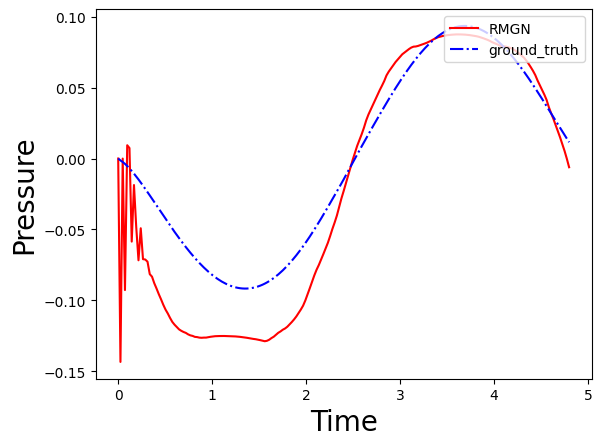

3.503233879804611

In [15]:
# Plot prediction/ground truth
import matplotlib.pyplot as plt

def plot_comparison(model, data):
    n_edge = data.edge_attr.size(0)
    hidden = torch.zeros(n_edge, args.hidden_dim).to(args.device)
    _x = data.x
    edge_index = data.edge_index.to(args.device)
    _edge_attr = data.edge_attr

    total_loss = 0
    total_node_out = [data.pressure[:,0].unsqueeze(1)]
    total_edge_out = [data.velocity[:,0].unsqueeze(1)]
    for i in range(1, args.n_time):
        model.eval()
        with torch.no_grad():
            _pressure = data.pressure[:,i-1].unsqueeze(1)
            _velocity = data.velocity[:,i-1].unsqueeze(1)
            _flowrate_bc = data.flowrate_bc[:,i].unsqueeze(1)
            x = torch.cat([_x, _pressure], dim=1).to(args.device)
            edge_attr = torch.cat([_edge_attr, _velocity, _flowrate_bc], dim=1).to(args.device)
            node_out, edge_out, hidden = model(x, edge_index, edge_attr, hidden)
            hidden = hidden.detach()

            loss = criterion(node_out, data.pressure[:,i].unsqueeze(1).float().to(args.device))
            loss += criterion(edge_out, data.velocity[:,i].unsqueeze(1).float().to(args.device))

            total_loss += loss.item()
            total_node_out.append(node_out.detach().cpu())
            total_edge_out.append(edge_out.detach().cpu())
    total_node_out = torch.cat(total_node_out, dim=1)
    total_edge_out = torch.cat(total_edge_out, dim=1)
    
    # plot
    node = 50000
    y_pred = total_node_out[node].numpy()
    y_true = data.pressure[node].numpy()
    x = [i * 4.8 /200 for i in range(201)]
    plt.plot(x, y_pred, c='red', label='RMGN')
    plt.plot(x, y_true, c='blue', linestyle='dashdot', label='ground_truth')
    # plt.ylim([-50,50])
    plt.legend(loc='upper right')
    plt.ylabel('Pressure', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.show()
    
    return total_loss
    
plot_comparison(model, dataset[40])